Colunas do dataset: ['channel', 'timestamp', 'value', 'label', 'sampling', 'anomaly', 'segment', 'train']
Exemplo de linhas:
    channel                 timestamp     value    label  sampling  anomaly  \
0  CADC0872 2022-06-01 23:42:54+00:00 -0.000021  anomaly         1        1   
1  CADC0872 2022-06-01 23:42:55+00:00 -0.000021  anomaly         1        1   
2  CADC0872 2022-06-01 23:42:56+00:00 -0.000021  anomaly         1        1   
3  CADC0872 2022-06-01 23:42:57+00:00 -0.000021  anomaly         1        1   
4  CADC0872 2022-06-01 23:42:58+00:00 -0.000021  anomaly         1        1   

   segment  train  
0      1.0    1.0  
1      1.0    1.0  
2      1.0    1.0  
3      1.0    1.0  
4      1.0    1.0  

Tamanho treino normal: 24337
Tamanho teste (com e sem anomalia): 12252

Shape X_train: (18083, 60, 1)
Shape X_test: (9243, 60, 1)
Distribuição de y_test: [5532 3711]

Treinando LSTM-AE...
Epoch 1/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 51s 352ms/step - loss: 0.3928 - val_loss: 0.0753 - 

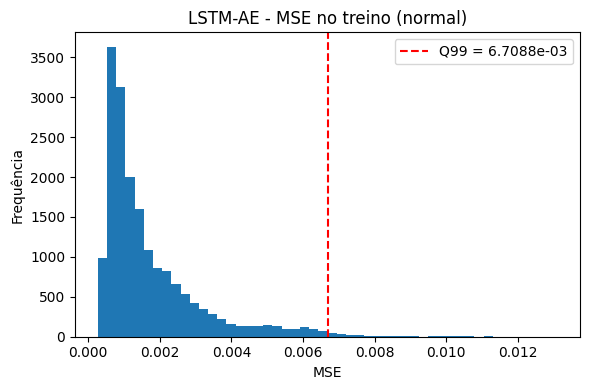


=== RESULTADOS LSTM-AE (threshold otimizado) ===
Threshold ótimo: 4.081627e-03
F1 (classe 1):   0.5360
Precisão (1):    0.8572
Recall (1):      0.3899
AUC-ROC:         0.7062
AUC-PR:          0.7102

Matriz de confusão:
[[5291  241]
 [2264 1447]]

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.7003    0.9564    0.8086      5532
           1     0.8572    0.3899    0.5360      3711

    accuracy                         0.7290      9243
   macro avg     0.7788    0.6732    0.6723      9243
weighted avg     0.7633    0.7290    0.6992      9243



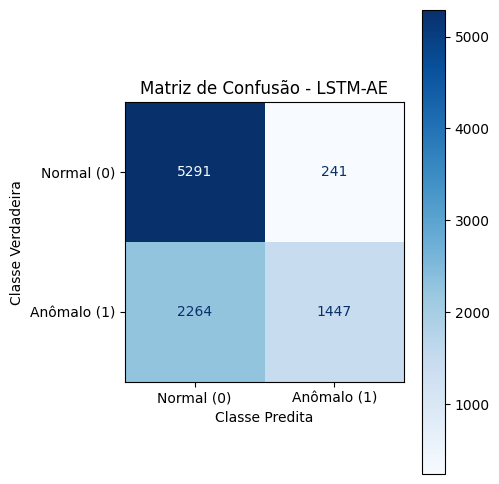

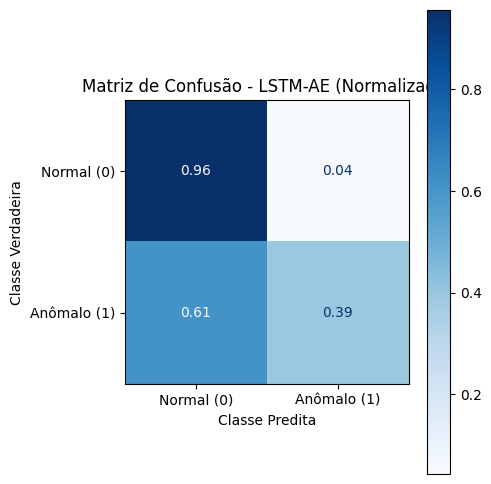

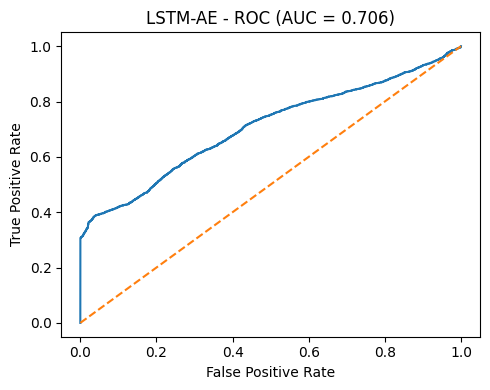

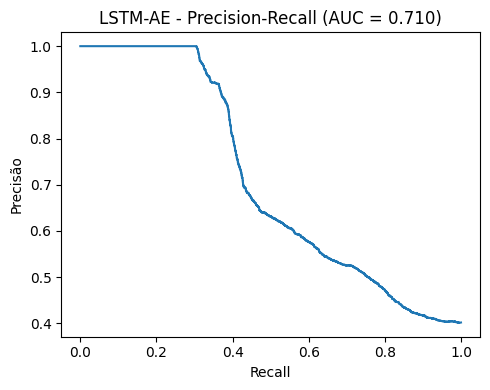


Treinando VAE...
Epoch 1/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 47s 317ms/step - kl_loss: 1.9612 - loss: 34.3651 - reconstruction_loss: 32.4039 - val_kl_loss: 4.2458 - val_loss: 12.9482 - val_reconstruction_loss: 8.7024 - learning_rate: 0.0010
Epoch 2/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - kl_loss: 3.1956 - loss: 21.8817 - reconstruction_loss: 18.6861 - val_kl_loss: 4.1894 - val_loss: 12.7936 - val_reconstruction_loss: 8.6043 - learning_rate: 0.0010
Epoch 3/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 35s 304ms/step - kl_loss: 4.2400 - loss: 11.7827 - reconstruction_loss: 7.5427 - val_kl_loss: 3.3766 - val_loss: 10.1353 - val_reconstruction_loss: 6.7587 - learning_rate: 0.0010
Epoch 4/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 36s 317ms/step - kl_loss: 4.0385 - loss: 9.4915 - reconstruction_loss: 5.4530 - val_kl_loss: 3.5027 - val_loss: 8.4746 - val_reconstruction_loss: 4.9719 - learning_rate: 0.0010
Epoch 5/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 291ms/step - kl_loss: 3.9354 - loss: 8.8991 - reconstruction_l

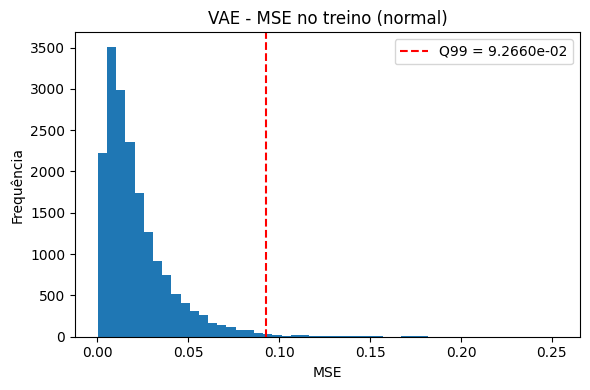


=== RESULTADOS VAE (threshold otimizado) ===
Threshold ótimo: 4.583590e-02
F1 (classe 1):   0.4461
Precisão (1):    0.6773
Recall (1):      0.3325
AUC-ROC:         0.6720
AUC-PR:          0.6367

Matriz de confusão:
[[4944  588]
 [2477 1234]]

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.6662    0.8937    0.7634      5532
           1     0.6773    0.3325    0.4461      3711

    accuracy                         0.6684      9243
   macro avg     0.6717    0.6131    0.6047      9243
weighted avg     0.6707    0.6684    0.6360      9243



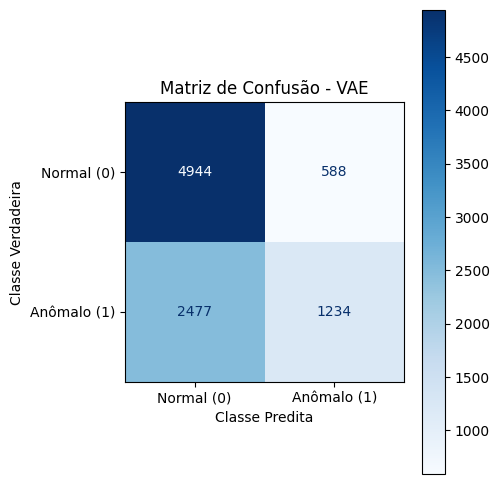

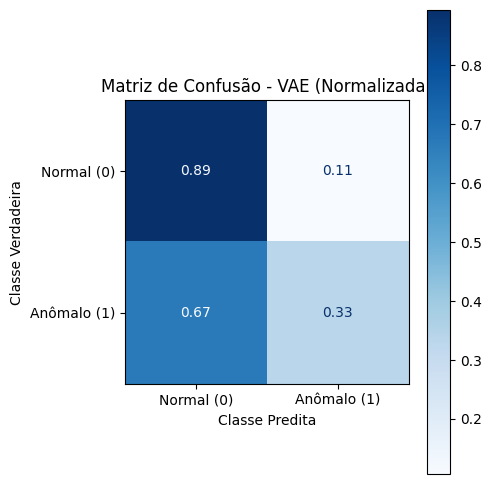

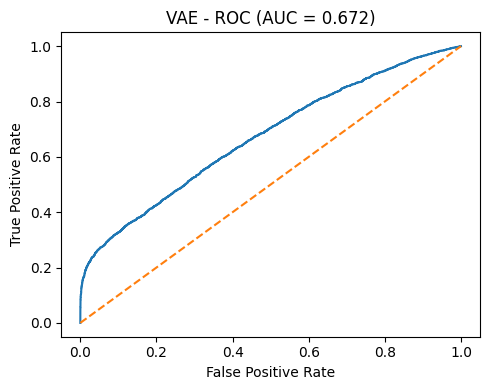

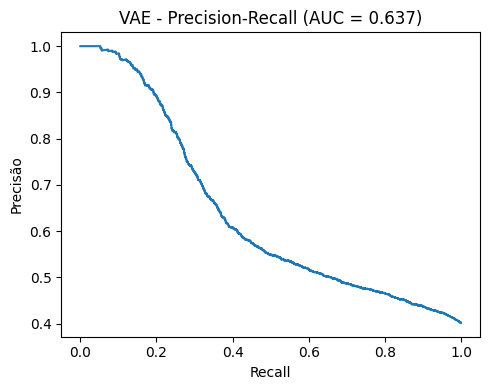


=== RESUMO MÉTRICAS (LSTM-AE vs VAE, threshold otimizado) ===
 modelo  threshold       F1  precisao   recall  AUC_ROC   AUC_PR
LSTM-AE   0.004082 0.536025  0.857227 0.389922 0.706172 0.710229
    VAE   0.045836 0.446051  0.677278 0.332525 0.671954 0.636733

=== MSE médio por classe (LSTM-AE vs VAE) ===
 modelo  MSE_normal  MSE_anomalo
LSTM-AE    0.001610     0.031971
    VAE    0.022215     0.058144


In [ ]:
# LSTM Autoencoder + VAE para detecção de anomalias em séries temporais

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
    roc_curve,
    ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow.keras import layers, models

# 1. CONFIGURAÇÕES

DATA_PATH = "segments.csv"
CANAL_ESCOLHIDO = "CADC0872"
SEQ_LEN = 60
LATENT_DIM = 16

EPOCHS_LSTM = 60
EPOCHS_VAE  = 60
BATCH_SIZE  = 128

np.random.seed(42)
tf.random.set_seed(42)


# 2. CARREGAR E PRÉ-PROCESSAR OS DADOS

segments = pd.read_csv(DATA_PATH)

segments["timestamp"] = pd.to_datetime(segments["timestamp"])
segments = segments.sort_values(["channel", "segment", "timestamp"])

print("Colunas do dataset:", segments.columns.tolist())
print("Exemplo de linhas:")
print(segments.head())

# Treino normal
train_normal = segments[
    (segments["train"] == 1) &
    (segments["anomaly"] == 0) &
    (segments["channel"] == CANAL_ESCOLHIDO)
].copy()

# Teste (normais + anômalos)
test_data = segments[
    (segments["train"] == 0) &
    (segments["channel"] == CANAL_ESCOLHIDO)
].copy()

print("\nTamanho treino normal:", len(train_normal))
print("Tamanho teste (com e sem anomalia):", len(test_data))

# Normalização
scaler = StandardScaler()
train_values = train_normal[["value"]].values
scaler.fit(train_values)

train_normal["value_norm"] = scaler.transform(train_values)
test_data["value_norm"] = scaler.transform(test_data[["value"]].values)

# 3. CRIAÇÃO DAS SEQUÊNCIAS (JANELAS)

def create_sequences_by_segment(df, seq_len, col="value_norm"):
    """
    Cria sequências de tamanho seq_len em cada segmento (sem rótulo).
    """
    sequences = []
    for seg_id, df_seg in df.groupby("segment"):
        vals = df_seg[col].values
        if len(vals) < seq_len:
            continue
        for i in range(len(vals) - seq_len + 1):
            seq = vals[i:i+seq_len]
            sequences.append(seq)
    return np.array(sequences)


def create_sequences_and_labels_by_segment(df, seq_len,
                                           col="value_norm",
                                           label_col="anomaly"):
    """
    Cria sequências + rótulos.
    Janela é rotulada como 1 se qualquer ponto tiver anomaly == 1.
    """
    X, y = [], []
    for seg_id, df_seg in df.groupby("segment"):
        vals = df_seg[col].values
        labels = df_seg[label_col].values
        if len(vals) < seq_len:
            continue
        for i in range(len(vals) - seq_len + 1):
            seq = vals[i:i+seq_len]
            lbl_window = labels[i:i+seq_len]
            X.append(seq)
            y.append(1 if np.any(lbl_window == 1) else 0)
    return np.array(X), np.array(y)


# Gera X_train, X_test, y_test
X_train = create_sequences_by_segment(train_normal, SEQ_LEN, col="value_norm")
X_test, y_test = create_sequences_and_labels_by_segment(
    test_data, SEQ_LEN, col="value_norm", label_col="anomaly"
)

# Adiciona dimensão de features
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print("\nShape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Distribuição de y_test:", np.bincount(y_test))

timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# 4. FUNÇÕES AUXILIARES (MSE, THRESHOLD, PLOTS)

def reconstruction_mse(model, X):
    """
    Retorna MSE de reconstrução por janela: vetor shape (n_amostras,).
    """
    X_pred = model.predict(X, verbose=0)
    mse = np.mean(np.mean(np.square(X - X_pred), axis=2), axis=1)
    return mse


def otimizar_threshold(train_mse, test_mse, y_test,
                       q_low=0.90, q_high=0.999, n_thresholds=50):
    """
    Busca thresholds entre os quantis q_low e q_high do MSE de treino.
    Otimiza F1 da classe 1.
    """
    q_low_val = np.quantile(train_mse, q_low)
    q_high_val = np.quantile(train_mse, q_high)

    thresholds = np.linspace(q_low_val, q_high_val, n_thresholds)

    best = {
        "threshold": None,
        "f1": -1.0,
        "precision": None,
        "recall": None,
        "report": None,
        "confusion": None,
        "roc_auc": None,
        "pr_auc": None
    }

    for thr in thresholds:
        y_pred = (test_mse > thr).astype(int)

        f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

        if f1 > best["f1"]:
            prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
            rec  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
            best.update({
                "threshold": thr,
                "f1": f1,
                "precision": prec,
                "recall": rec,
                "report": classification_report(y_test, y_pred, digits=4),
                "confusion": confusion_matrix(y_test, y_pred)
            })

    # AUC-ROC e AUC-PR (não dependem de threshold)
    try:
        best["roc_auc"] = roc_auc_score(y_test, test_mse)
    except ValueError:
        best["roc_auc"] = np.nan

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, test_mse)
    best["pr_auc"] = auc(recall_curve, precision_curve)

    return best


def plot_confusion(cm, title):
    labels = ["Normal (0)", "Anômalo (1)"]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(cmap="Blues", ax=ax, values_format="d")
    plt.title(title)
    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Verdadeira")
    plt.tight_layout()
    plt.show()

    # Normalizada
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                                       display_labels=labels)
    fig, ax = plt.subplots(figsize=(5,5))
    disp_norm.plot(cmap="Blues", ax=ax, values_format=".2f")
    plt.title(title + " (Normalizada)")
    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Verdadeira")
    plt.tight_layout()
    plt.show()


def plot_roc_pr(y_true, scores, model_name, roc_auc_val, pr_auc_val):
    fpr, tpr, _ = roc_curve(y_true, scores)
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, scores)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC (AUC = {roc_auc_val:.3f})")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(recall_curve, precision_curve)
    plt.xlabel("Recall")
    plt.ylabel("Precisão")
    plt.title(f"{model_name} - Precision-Recall (AUC = {pr_auc_val:.3f})")
    plt.tight_layout()
    plt.show()

# 5. LSTM AUTOENCODER

def build_lstm_autoencoder(timesteps, n_features):
    inputs = layers.Input(shape=(timesteps, n_features))

    # Encoder
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(32, return_sequences=False)(x)

    # Latente repetido no tempo
    encoded = layers.RepeatVector(timesteps)(x)

    # Decoder
    x = layers.LSTM(32, return_sequences=True)(encoded)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    outputs = layers.TimeDistributed(layers.Dense(n_features))(x)

    model = models.Model(inputs, outputs, name="LSTM_AE")
    model.compile(optimizer="adam", loss="mse")
    return model

lstm_ae = build_lstm_autoencoder(timesteps, n_features)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

print("\nTreinando LSTM-AE...")
history_lstm = lstm_ae.fit(
    X_train,
    X_train,
    epochs=EPOCHS_LSTM,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Avaliação LSTM-AE
train_mse_lstm = reconstruction_mse(lstm_ae, X_train)
test_mse_lstm  = reconstruction_mse(lstm_ae, X_test)

# Visualização do MSE de treino (Q99)
thr_lstm_q99 = np.quantile(train_mse_lstm, 0.99)
plt.figure(figsize=(6,4))
plt.hist(train_mse_lstm, bins=50)
plt.axvline(thr_lstm_q99, color="r", linestyle="--", label=f"Q99 = {thr_lstm_q99:.4e}")
plt.xlabel("MSE")
plt.ylabel("Frequência")
plt.title("LSTM-AE - MSE no treino (normal)")
plt.legend()
plt.tight_layout()
plt.show()

best_lstm = otimizar_threshold(train_mse_lstm, test_mse_lstm, y_test)

print("\n=== RESULTADOS LSTM-AE (threshold otimizado) ===")
print(f"Threshold ótimo: {best_lstm['threshold']:.6e}")
print(f"F1 (classe 1):   {best_lstm['f1']:.4f}")
print(f"Precisão (1):    {best_lstm['precision']:.4f}")
print(f"Recall (1):      {best_lstm['recall']:.4f}")
print(f"AUC-ROC:         {best_lstm['roc_auc']:.4f}")
print(f"AUC-PR:          {best_lstm['pr_auc']:.4f}")
print("\nMatriz de confusão:")
print(best_lstm["confusion"])
print("\nRelatório de classificação:")
print(best_lstm["report"])

plot_confusion(best_lstm["confusion"], "Matriz de Confusão - LSTM-AE")
plot_roc_pr(y_test, test_mse_lstm, "LSTM-AE",
            best_lstm["roc_auc"], best_lstm["pr_auc"])

# 6. VAE (VARIATIONAL AUTOENCODER)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# Encoder VAE
encoder_inputs = layers.Input(shape=(timesteps, n_features))

x = layers.LSTM(64, return_sequences=True)(encoder_inputs)
x = layers.LSTM(32, return_sequences=False)(x)

z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")


# Decoder VAE
latent_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.RepeatVector(timesteps)(latent_inputs)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
decoder_outputs = layers.TimeDistributed(layers.Dense(n_features))(x)

decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")


class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # reconstrução: MSE somado ao longo de tempo e features
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=(1,2))
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(data - reconstruction), axis=(1,2))
        )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        # Para que vae(inputs) retorne a reconstrução e possamos usar reconstruction_mse
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction


vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

print("\nTreinando VAE...")
history_vae = vae.fit(
    X_train,
    epochs=EPOCHS_VAE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Avaliação VAE
train_mse_vae = reconstruction_mse(vae, X_train)
test_mse_vae  = reconstruction_mse(vae, X_test)

thr_vae_q99 = np.quantile(train_mse_vae, 0.99)
plt.figure(figsize=(6,4))
plt.hist(train_mse_vae, bins=50)
plt.axvline(thr_vae_q99, color="r", linestyle="--", label=f"Q99 = {thr_vae_q99:.4e}")
plt.xlabel("MSE")
plt.ylabel("Frequência")
plt.title("VAE - MSE no treino (normal)")
plt.legend()
plt.tight_layout()
plt.savefig("lstm_ae_mse_treino.png", dpi=300, bbox_inches="tight")
plt.show()

best_vae = otimizar_threshold(train_mse_vae, test_mse_vae, y_test)

print("\n=== RESULTADOS VAE (threshold otimizado) ===")
print(f"Threshold ótimo: {best_vae['threshold']:.6e}")
print(f"F1 (classe 1):   {best_vae['f1']:.4f}")
print(f"Precisão (1):    {best_vae['precision']:.4f}")
print(f"Recall (1):      {best_vae['recall']:.4f}")
print(f"AUC-ROC:         {best_vae['roc_auc']:.4f}")
print(f"AUC-PR:          {best_vae['pr_auc']:.4f}")
print("\nMatriz de confusão:")
print(best_vae["confusion"])
print("\nRelatório de classificação:")
print(best_vae["report"])

plot_confusion(best_vae["confusion"], "Matriz de Confusão - VAE")
plot_roc_pr(y_test, test_mse_vae, "VAE",
            best_vae["roc_auc"], best_vae["pr_auc"])

# 7. TABELA RESUMO LSTM-AE vs VAE

resumo = pd.DataFrame({
    "modelo":   ["LSTM-AE", "VAE"],
    "threshold": [best_lstm["threshold"], best_vae["threshold"]],
    "F1":       [best_lstm["f1"],        best_vae["f1"]],
    "precisao": [best_lstm["precision"], best_vae["precision"]],
    "recall":   [best_lstm["recall"],    best_vae["recall"]],
    "AUC_ROC":  [best_lstm["roc_auc"],   best_vae["roc_auc"]],
    "AUC_PR":   [best_lstm["pr_auc"],    best_vae["pr_auc"]],
})

def mse_por_classe(test_mse, y_true):
    return test_mse[y_true == 0].mean(), test_mse[y_true == 1].mean()

mse_norm_lstm, mse_anom_lstm = mse_por_classe(test_mse_lstm, y_test)
mse_norm_vae,  mse_anom_vae  = mse_por_classe(test_mse_vae,  y_test)

mse_resumo = pd.DataFrame({
    "modelo":      ["LSTM-AE", "VAE"],
    "MSE_normal":  [mse_norm_lstm, mse_norm_vae],
    "MSE_anomalo": [mse_anom_lstm, mse_anom_vae],
})

print("\n=== RESUMO MÉTRICAS (LSTM-AE vs VAE, threshold otimizado) ===")
print(resumo.to_string(index=False))

print("\n=== MSE médio por classe (LSTM-AE vs VAE) ===")
print(mse_resumo.to_string(index=False))
